In [1]:
import numpy as np
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import Distance
import matplotlib.pyplot as plt
# gammapy
from gammapy.spectrum import FluxPoints, FluxPointsDataset
from gammapy.modeling.models import SpectralModel, SkyModel
from gammapy.modeling import Parameter, Fit
# agnpy
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton

In [2]:
ecsv_tab = Table.read("sed_mrk421.ecsv")
fluxpoints_tab = Table() 

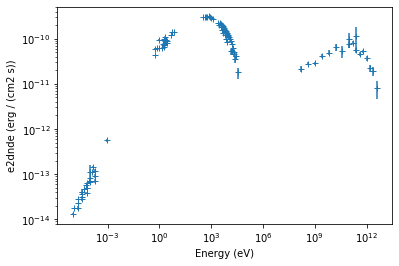

In [3]:
fluxpoints_tab["e_ref"] = ecsv_tab["x"].to("eV", equivalencies=u.spectral())
fluxpoints_tab["e2dnde"] = ecsv_tab["y"]
fluxpoints_tab["e2dnde_err"] = ecsv_tab["dy"]
fluxpoints_tab.meta['SED_TYPE'] = "e2dnde"

flux_points = FluxPoints(fluxpoints_tab)
flux_points.plot(energy_unit="eV")

In [4]:
# let's draw a tentative SED, before the fit
# blob definition
spectrum_norm = 1e48 * u.erg
parameters = {
        "p1": 2.0,
        "p2": 3.6,
        "gamma_b": 1e5,
        "gamma_min": 50,
        "gamma_max": 2e6,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
R_b = 5e16 * u.cm
B = 0.1 * u.G
z = 0.03
delta_D = 10
Gamma = 10
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

# sycnh and ssc radiation definition
synch = Synchrotron(blob)
ssc = SynchrotronSelfCompton(blob, synch)

nu = np.logspace(9, 27) * u.Hz
sed = synch.sed_flux(nu) + ssc.sed_flux(nu)

normalising broken power-law to total energy density u_e: 1.91e-03 erg / cm3


/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/agnpy/compton.py:24: RuntimeWarning: invalid value encountered in log
  term_1 = 2 * q * np.log(q)


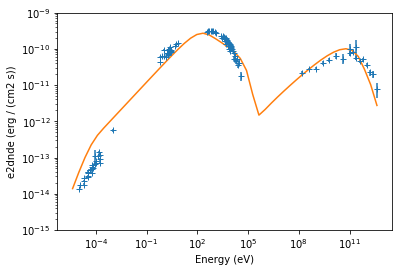

In [5]:
fig, ax = plt.subplots()
flux_points.plot(energy_unit="eV", ax=ax)
e = nu.to("eV", equivalencies=u.spectral())
ax.loglog(e, sed)
ax.set_ylim([1e-15, 1e-9])
plt.show()

In [6]:
class SSC(SpectralModel):
    r"""Spectral model with agnpy synchrotron self Compton Radiation
    """
    
    tag = "agnpySSC"
    spectrum_norm = Parameter("spectrum_norm", "1e48 erg")
    p1 = Parameter("p1", 2.0)
    p2 = Parameter("p2", 3.6)
    gamma_b = Parameter("gamma_b", 1e5)
    B = Parameter("B", "0.1 G")
    
    @staticmethod
    def evaluate(energy, spectrum_norm, p1, p2, gamma_b, B):
        nu = energy.to("Hz", equivalencies=u.spectral())
        
        parameters = {
            "p1": p1,
            "p2": p2,
            "gamma_b": gamma_b,
            "gamma_min": 50,
            "gamma_max": 2e6,
        }
        spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
        R_b = 5e16 * u.cm
        z = 0.03
        delta_D = 10
        Gamma = 10
        blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)
        
        # sycnh and ssc radiation definition
        synch = Synchrotron(blob)
        ssc = SynchrotronSelfCompton(blob, synch)

        sed = synch.sed_flux(nu) + ssc.sed_flux(nu)
        
        return (sed / np.power(energy, 2))

In [9]:
ssc_model = SSC()
model = SkyModel(spectral_model=ssc_model)
dataset_ssc = FluxPointsDataset(model, flux_points.to_sed_type("dnde"))
fitter = Fit([dataset_ssc])
result_ssc = fitter.run()

RuntimeError: exception was raised in user function
User function arguments:
    par_000_spectrum_norm = +1.000000
               par_001_p1 = +2.000000
               par_002_p2 = +3.600000
          par_003_gamma_b = +1.000000
                par_004_B = +1.000000
Original python exception in user function:
AttributeError: 'Blob' object has no attribute 'n_e'
  File "/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/gammapy/modeling/iminuit.py", line 17, in fcn
    return self.function()
  File "/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/gammapy/modeling/datasets.py", line 149, in stat_sum
    stat_sum += dataset.stat_sum()
  File "/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/gammapy/modeling/datasets.py", line 55, in stat_sum
    stat = self.stat_array()
  File "/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/gammapy/spectrum/flux_point.py", line 1359, in stat_array
    model = self.flux_pred()
  File "/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/gammapy/spectrum/flux_point.py", line 1354, in flux_pred
    flux += component.spectral_model(self.data.e_ref)
  File "/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/gammapy/modeling/models/spectral.py", line 63, in __call__
    return self.evaluate(energy, **kwargs)
  File "<ipython-input-6-66a347560d4a>", line 32, in evaluate
    ssc = SynchrotronSelfCompton(blob, synch)
  File "/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/agnpy/compton.py", line 152, in __init__
    self.epsilon_syn
  File "/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/agnpy/synchrotron.py", line 130, in com_sed_emissivity
    N_e = self.blob.N_e(gamma).value
  File "/Users/cosimo/software/miniconda3/envs/gammapy-0.16/lib/python3.7/site-packages/agnpy/emission_regions.py", line 150, in N_e
    return self.V_b * self.n_e(gamma)
